# Object-oriented FISSA interface

This notebook contains a step-by-step example of how to use the object-oriented (class-based) interface to the [FISSA](https://github.com/rochefort-lab/fissa) toolbox.

The object-oriented interface, which involves creating a [fissa.Experiment](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment) instance, allows more flexiblity than the [fissa.run_fissa](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.run_fissa) function.

For more details about the methodology behind FISSA, please see our paper:

Keemink, S. W., Lowe, S. C., Pakan, J. M. P., Dylda, E., van Rossum, M. C. W., and Rochefort, N. L. FISSA: A neuropil decontamination toolbox for calcium imaging signals, *Scientific Reports*, **8**(1):3493, 2018. doi: [10.1038/s41598-018-21640-2](https://www.doi.org/10.1038/s41598-018-21640-2).

See [basic_usage.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage.py) (or [basic_usage_windows.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage_windows.py) for Windows users) for a short example script outside of a notebook interface.

In [1]:
import os
import glob
import sys 

import h5py
import cv2
import logging

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np


try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.paths import caiman_datadir
from caiman.source_extraction.volpy import utils
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
from caiman.utils.utils import download_demo, download_model

sys.path.append(r'C:\Gomez\Analysis\2PVoltage_Imaging_Analysis_Pipeline')
from fxns.raw2tiff import *
from fxns.volpy_unpack import *
from caiman_data.fxns_caiman.plotting_fxns import *

C:\Users\LCG\AppData\Local\Temp\ipykernel_58348\292946207.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
C:\Users\LCG\AppData\Local\Temp\ipykernel_58348\292946207.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


In [2]:
def process_raw(movie_paths, mk_rawdir = False, convert = False, split = True, **kwargs):
    '''
    Process raw movies and get metadata
    '''
    exp_names = []
    tif_path = []
    exp_dir = []
    exp_metadata = dict()
    for movie in movie_paths:
        exps, metadata = raw2tiff(movie,mk_rawdir, convert, split)
        for exp in exps:
            print('Processing '+ exp)
            globals()[exp] = metadata[exp]
            globals()[exp]['file_path_ch1'] = os.path.join(metadata[exp]['exp_path'], 'analysis', 'mean_rois_ch1.csv')
            stack_path = os.path.join(metadata[exp]['exp_path'], 'tif_stack', metadata[exp]['exp_name'] + '.tif')
            tif_path += [stack_path]
            exp_dir += [os.path.split(os.path.split(stack_path)[0])[0]]
        exp_names = exp_names + exps
        exp_metadata.update(metadata)
    
    # print(exp_names)
    return tif_path, exp_names, exp_dir

In [3]:
def get_exp_paths(exp):
    stack_path = [file for file in tif_path if exp in file]
    dir_path = [file for file in exp_dir if exp in file]
    exp_name = [file for file in exp_names if exp in file]
    return stack_path, dir_path, exp_name

In [4]:
## Process Exps: Convert Raw to Tiff Stack and Collect MetaData + Get Save path 
movie_paths = [r'E:\M057\2024-02-02\MWD']
tif_path, exp_names, exp_dir = process_raw(movie_paths, mk_rawdir = False, convert = False, split = True)

Processing FOV1_MWD
Processing FOV1_Oddball
Processing FOV2_MWD
Processing FOV2_Oddball
Processing FOV3_MWD
Processing FOV3_Oddball


In [5]:
# Set motion correction parameters

opts_dict = {}
opts_dict['113Hz'] = {
    'fr': 113, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (5, 5),  # maximum allowed rigid shift
    'gSig_filt': (3, 3), # size of filter
    'strides': (48, 48) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (24, 24),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}
opts_dict['147Hz'] = {
    'fr': 147, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (5, 5),  # maximum allowed rigid shift
    'gSig_filt': (3, 3), # size of filter
    'strides': (32, 32) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (16, 16),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}
opts_dict['152Hz'] = {
    'fr': 153, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (5, 5),  # maximum allowed rigid shift
    'gSig_filt': (3, 3), # size of filter
    'strides': (32, 32) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (16, 16),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}
opts_dict['220Hz'] = {
    'fr': 220, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (7, 7),  # maximum allowed rigid shift
    'gSig_filt': (3, 2), # size of filter
    'strides': (32, 24) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (16, 12),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}
opts_dict['220Hz_awake'] = {
    'fr': 220, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (10,10),  # maximum allowed rigid shift
    'gSig_filt': (3, 3), # size of filter
    'strides': (32, 24) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (16, 12),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}
opts_dict['397Hz_awake'] = {
    'fr': 397, # hz
    'pw_rigid': False,# flag for pw-rigid motion correction
    'max_shifts': (15, 15),  # maximum allowed rigid shift
    'gSig_filt': None, # size of filter
    'strides': (32, 24) ,  # start a new patch for pw-rigid motion correction every x pixels
    'overlaps': (16, 12),  # overlap between pathes (size of patch strides+overlaps)
    'max_deviation_rigid': 3, # maximum deviation allowed for patch with respect to rigid shifts
    'border_nan': 'copy'
}

In [6]:
# Set Volparams Opts
stack_path, dir_path, exps = get_exp_paths('FOV2')

opts_final = opts_dict['397Hz_awake']
opts_final['fnames'] = stack_path
opts = volparams(params_dict=opts_final)

In [7]:
# %% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [8]:
mc = MotionCorrect(stack_path, dview=dview, **opts.get_group('motion'))
mc_list = []
mc_list_ch2 = []
for exp in stack_path:
    # Load mmap file 
    mmap_file = [file for file in os.listdir(os.path.split(exp)[0]) if '.mmap' in file]
    mmap_file_ch1 = [file for file in mmap_file if 'rig' in file] # ensures ch1 is loaded
    mmap_file_ch2 = [file for file in mmap_file if 'ch2' in file] # ensures ch1 is loaded 
    mc_list += [os.path.join(os.path.split(exp)[0], mmap_file_ch1[0])]
    mc_list_ch2 += [os.path.join(os.path.split(exp)[0], mmap_file_ch2[0])]
print('mmap list ch1:')
print(mc_list)
print('mmap list ch2:')
print(mc_list_ch2)
mc.mmap_file = [mc_list[0]]
# print(f'reuse previously saved motion corrected file:{mc.mmap_file}')

mmap list ch1:
['E:\\M057\\2024-02-02\\MWD\\FOV2\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_MWD\\tif_stack\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_MWD_rig__d1_32_d2_512_d3_1_order_F_frames_360000_.mmap', 'E:\\M057\\2024-02-02\\MWD\\FOV2\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_Oddball\\tif_stack\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_Oddball_rig__d1_32_d2_512_d3_1_order_F_frames_360000_.mmap']
mmap list ch2:
['E:\\M057\\2024-02-02\\MWD\\FOV2\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_MWD\\tif_stack\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_MWD_ch2_d1_32_d2_512_d3_1_order_C_frames_360000_.mmap', 'E:\\M057\\2024-02-02\\MWD\\FOV2\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_Oddball\\tif_stack\\2024-02-02_M057_Drd3-cre_ASAP6-1_jRGECO1a_FOV2_Oddball_ch2_d1_32_d2_512_d3_1_order_C_frames_360000_.mmap']


In [9]:
def get_x_file_paths(movie_paths, ending):
    file_paths = []
    for root, _, files in os.walk(movie_paths):
        for file in files:
            if file.endswith(ending):
                file_paths.append(os.path.join(root, file))
    return file_paths

## Import packages

Before we can begin, we need to import fissa.

In [10]:
# Import the FISSA toolbox
import fissa

We also need to import some plotting dependencies which we'll make use in this notebook to display the results.

In [11]:
# For plotting our results, import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
colors = plt.get_cmap("Paired")

## Defining an experiment

To run a separation step with fissa, you need create a [fissa.Experiment](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment) object, which will hold your extraction parameters and results.

The mandatory inputs to `fissa.Experiment` are:

- the experiment images
- the regions of interest (ROIs) to extract

Images can be given as a path to a folder containing tiff stacks:
```python
images = "folder"
```
Each of these tiff-stacks in the folder (e.g. `"folder/trial_001.tif"`) is a trial with many frames.
Although we refer to one trial as an `image`, it is actually a video recording.

Alternatively, the image data can be given as a list of paths to tiffs:
```python
images = ["folder/trial_001.tif", "folder/trial_002.tif", "folder/trial_003.tif"]
```
or as a list of arrays which you have already loaded into memory:
```python
images = [array1, array2, array3, ...]
```

For the regions of interest (ROIs) input, you can either provide a single set of ROIs, or a set of ROIs for every image.

If the ROIs were defined using ImageJ, use ImageJ's export function to save them in a zip.
Then, provide the ROI filename.
```python
rois = "rois.zip"  # for a single set of ROIs used across all images
```
The same set of ROIs will be used for every image in `images`.

Sometimes there is motion between trials causing the alignment of the ROIs to drift.
In such a situation, you may need to use a slightly different location of the ROIs for each trial.
This can be handled by providing FISSA with a list of ROI sets — one ROI set (i.e. one ImageJ zip file) per trial.
```python
rois = ["rois1.zip", "rois2.zip", ...]  # for a unique roiset for each image
```
Please note that the ROIs defined in each ROI set must correspond to the same physical reigons across all trials, and that the order must be consistent.
That is to say, the 1st ROI listed in each ROI set must correspond to the same item appearing in each trial, etc.

In this notebook, we will demonstrate how to use FISSA with ImageJ ROI sets, saved as zip files.
However, you are not restricted to providing your ROIs to FISSA in this format.
FISSA will also accept ROIs which are arbitrarily defined by providing them as arrays (`numpy.ndarray` objects).
ROIs provided in this way can be defined either as boolean-valued masks indicating the presence of a ROI per-pixel in the image, or defined as a list of coordinates defining the boundary of the ROI.
For examples of such usage, see our [Suite2p](https://fissa.readthedocs.io/en/latest/examples/Suite2p%20example.html), [CNMF](https://fissa.readthedocs.io/en/latest/examples/cNMF%20example.html), and [SIMA](https://fissa.readthedocs.io/en/latest/examples/SIMA%20example.html) example notebooks.

As an example, we will run FISSA on a small test dataset.

The test dataset can be found and downloaded from [the examples folder of the fissa repository](https://github.com/rochefort-lab/fissa/tree/master/examples), along with the source for this example notebook.

In [40]:
from PIL import Image
from scipy import ndimage

## MAIN FUNCTION FOR STEP 2
methods_list = ['manual_annotation',       # manual annotations need prepared annotated datasets in the same format as demo_voltage_imaging_ROIs.hdf5 
                'semi-manual_annotation',                # Mask R-CNN is a convolutional neural network trained for detecting neurons in summary images
                'gui_annotation']          # use VolPy GUI to correct outputs of Mask R-CNN or annotate new datasets 

def get_rois(file, method,joint_analysis = True, **kwargs):

    if method == 'manual_annotation':
        print(method)
        path_ROIs = [os.path.join(os.path.split(os.path.split(file)[0])[0], 'analysis', 'roi_masks.h5')]
        with h5py.File(path_ROIs[0], 'r') as fl:
            ROIs = fl['mov'][()]
        
    elif method == 'semi-manual_annotation':    # draw ROIs in ImageJ, save binar mask and separate in python 
        print(method)
        # Determine if use single Masks.tif or individual Mask.tiff
        if joint_analysis: # use single ROI mask 
            mask_path = os.path.join(os.path.split(os.path.split(file)[0])[0], 'analysis', 'Masks.tif')
        else:
            mask_path = os.path.join(os.path.split(os.path.split(file)[0])[0], 'analysis', 'Masks.tif')

        # roi_path = get_x_file_paths(os.path.join(exp_dir[file_no],'analysis'), 'Masks.tif')
        roi_stack = separate_rois(mask_path)
        path_ROIs = save_roi_masks(roi_stack,file)

        with h5py.File(path_ROIs, 'r') as fl:
            print(fl)
            ROIs = fl['mov'][()]

    elif method == 'gui_annotation':
        print(method)
        # run volpy_gui.py file in the caiman/source_extraction/volpy folder
        gui_ROIs =  os.path.join(fnames[0][:-4] + '_mrcnn_ROIs.hdf5')
        with h5py.File(gui_ROIs, 'r') as fl:
            ROIs = fl['mov'][()]
    return ROIs, mask_path, path_ROIs

def separate_rois(binary_mask_path):
    # Load the binary mask image
    binary_mask = np.array(Image.open(binary_mask_path))

    # Perform connected component labeling
    labeled_mask, num_labels = ndimage.label(binary_mask)

    # Create a stack of binary mask images
    roi_stack = []
    for label in range(1, num_labels + 1):  # Skip label 0 (background)
        # Create a binary mask for the current ROI label
        roi_mask = np.where(labeled_mask == label, 255, 0)

        # Add the binary mask to the stack
        roi_stack.append(roi_mask)

    return roi_stack

def save_roi_masks(roi_masks,mmap_file):
    save_path = os.path.join(os.path.split(os.path.split(mmap_file)[0])[0],'analysis', 'roi_masks.h5')
    if not os.path.isdir(os.path.split(save_path)[0]):
        os.mkdir(os.path.split(save_path)[0])
        
    hf = h5py.File(save_path, 'w')
    hf.create_dataset('mov', data=roi_masks, dtype='uint8')
    hf.close()

    return save_path

In [124]:
# Load mmap files
dir_path =  exp_dir[2]
Yr, dims, T = cm.load_memmap(mc.mmap_file[0])
image_stack = np.reshape(Yr.T, [T] + list(dims), order='F') 

# load rois and convert to binary array
roi_zip_path =get_x_file_paths(dir_path, '.zip')
rois_location = roi_zip_path[0]
ROIs, _, _ =  get_rois(mc.mmap_file[0], methods_list[1]) # joint analysis uses same ROI masks across all movies 
ROI_list = [np.squeeze(item) for item in np.split(ROIs, ROIs.shape[0], axis=0)]
binary_mask_list = [roi == np.max(np.unique(ROIs)) for roi in ROI_list]

save_path = os.path.join(dir_path, 'analysis')

# Call FISSA using the function-based interface

# Create the experiment object
experiment = fissa.Experiment([image_stack], 
                              [binary_mask_list],
                              expansion = 1,  
                              verbosity =1, 
                              method = 'ica', 
                              folder = save_path)

semi-manual_annotation
<HDF5 file "roi_masks.h5" (mode r)>


### Extracting traces and separating them

Now we have our experiment object, we need to call the [separate()](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment.separate) method to run FISSA on the data.
FISSA will extract the traces, and then separate them.

In [126]:
experiment.separate()

onput not filename


Extracting traces:   0%|          | 0/1 [00:00<?, ?it/s]

Finished extracting raw signals from 15 ROIs across 1 trials in 12 min, 39 sec.


Separating data:   0%|          | 0/15 [00:00<?, ?it/s]

Finished separating signals from 15 ROIs across 1 trials in 26 min, 29 sec


## Accessing results

After running [experiment.separate()](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment.separate) the analysis parameters, raw traces, output signals, ROI definitions, and mean images are stored as attributes of the experiment object, and can be accessed as follows.

### Mean image

The temporal-mean image for each trial is stored in `experiment.means`.

We can read out and plot the mean of one of the trials as follows.

In [127]:
%matplotlib inline

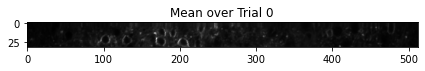

In [128]:
trial = 0
# Plot the mean image for one of the trials
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
plt.title("Mean over Trial {}".format(trial))
plt.show()

Plotting the mean image for each trial can be useful to see if there is motion drift between trials.

As a summary, you can also take the mean over all trials.
Some cells don't appear in every trial, so the overall mean may indicate the location of more cells than the mean image from a single trial.

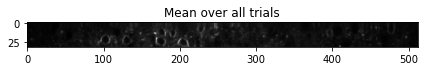

In [129]:
# Plot the mean image over all the trials
plt.figure(figsize=(7, 7))
plt.imshow(np.mean(experiment.means, axis=0), cmap="gray")
plt.title("Mean over all trials")
plt.show()

### ROI outlines

The ROI outlines, and the definitions of the surrounding neuropil regions added by FISSA to determine the contaminating signals, are stored in the ``experiment.roi_polys`` attribute.
For cell number ```c``` and TIFF number `t`, the set of ROIs for that cell and TIFF is located at
```python
experiment.roi_polys[c, t][0][0]  # user-provided ROI, converted to polygon format
experiment.roi_polys[c, t][n][0]  # n = 1, 2, 3, ... the neuropil regions
```

Sometimes ROIs cannot be expressed as a single polygon (e.g. a ring-ROI, which needs a line for the outside and a line for the inside); in those cases several polygons are used to describe it as:
```python
experiment.roi_polys[c, t][n][i]  # i iterates over the series of polygons defining the ROI
```

As an example, we will plot the first ROI along with its surrounding neuropil subregions, overlaid on top of the mean image for one trial.

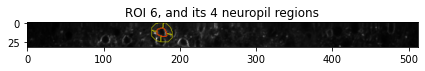

In [130]:
# Plot one ROI along with its neuropil regions

# Select which ROI and trial to plot
trial = 0
roi = 6

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
# Get current axes limits
XLIM = plt.xlim()
YLIM = plt.ylim()

# Check the number of neuropil regions
n_npil = len(experiment.roi_polys[roi, trial]) - 1

# Plot all the neuropil regions in yellow
for i_npil in range(1, n_npil + 1):
    for contour in experiment.roi_polys[roi, trial][i_npil]:
        plt.fill(
            contour[:, 1],
            contour[:, 0],
            facecolor="none",
            edgecolor="y",
            alpha=0.6,
        )

# Plot the ROI outline in red
for contour in experiment.roi_polys[roi, trial][0]:
    plt.fill(
        contour[:, 1],
        contour[:, 0],
        facecolor="none",
        edgecolor="r",
        alpha=0.6,
    )

# Reset axes limits to be correct for the image
plt.xlim(XLIM)
plt.ylim(YLIM)

plt.title("ROI {}, and its {} neuropil regions".format(roi, experiment.nRegions))
plt.show()

Similarly, we can plot the location of all 4 ROIs used in this experiment.

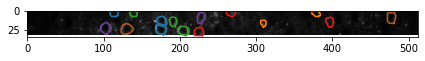

In [131]:
# Plot all cell ROI locations

# Select which trial (TIFF index) to plot
trial = 0

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")

# Plot each of the cell ROIs
for i_roi in range(len(experiment.roi_polys)):
    # Plot border around ROI
    for contour in experiment.roi_polys[i_roi, trial][0]:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            color=colors((i_roi * 2 + 1) % colors.N),
        )

plt.show()

### FISSA extracted traces

The final signals after separation can be found in ``experiment.result`` as follows.
For cell number ``c`` and TIFF number ``t``, the extracted trace is given by:
```python
experiment.result[c, t][0, :]
```

In ``experiment.result`` one can find the signals present in the cell ROI, ordered by how strongly they are present (relative to the surrounding regions). ``experiment.result[c, t][0, :]`` gives the most strongly present signal, and is considered the cell's "true" signal. ``[i, :]`` for ``i=1,2,3,...`` gives the other signals which are present in the ROI, but driven by other cells or neuropil.

### Before decontamination

The raw extracted signals can be found in ``experiment.raw`` in the same way. Now in  ``experiment.raw[c, t][i, :]``, ``i`` indicates the region number, with ``i=0`` being the cell, and ``i=1,2,3,...`` indicating the surrounding regions.

As an example, plotting the raw and extracted signals for the second trial for the third cell:

In [135]:
# Plot sample trace
%matplotlib qt
# Select the ROI and trial to plot
roi = 6
trial = 0

# Create the figure
plt.figure(figsize=(12, 6))

plt.plot(
    experiment.raw[roi, trial][0, :],
    lw=2,
    label="Raw",
    color=colors((roi * 2) % colors.N),
)
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=colors((roi * 2 + 1) % colors.N),
)

plt.title("ROI {},  Trial {}".format(roi, trial), fontsize=15)
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

We can similarly plot raw and decontaminated traces for every ROI and every trial.

In [136]:
# Plot all ROIs and trials

# Get the number of ROIs and trials
n_roi = experiment.result.shape[0]
n_trial = experiment.result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max_raw = [
    np.max([np.max(experiment.raw[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max([np.max(experiment.result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            experiment.raw[i_roi][i_trial][0, :],
            label="Raw",
            color=colors((i_roi * 2) % colors.N),
        )
        plt.plot(
            experiment.result[i_roi][i_trial][0, :],
            label="Decontaminated",
            color=colors((i_roi * 2 + 1) % colors.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
            plt.legend()
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")

plt.show()

The figure above shows the raw signal from the annotated ROI location (pale), and the result after decontaminating the signal with FISSA (dark).
The hues match the ROI locations drawn above.
Each column shows the results from one of the ROI, and each row shows the results from one of the three trials.

### Comparing ROI signal to neuropil region signals
It can be very instructive to compare the signal in the central ROI with the surrounding neuropil regions. These can be found for cell `c` and trial `t` in `experiment.raw[c, t][i, :]`, with `i=0` being the cell, and `i=1,2,3,...` indicating the surrounding regions.

Below we compare directly the raw ROI trace, the decontaminated trace, and the surrounding neuropil region traces.

In [143]:
# Get the total number of regions
nRegions = experiment.nRegions

# Select the ROI and trial to plot
roi = 6
trial = 0

# Create the figure
plt.figure(figsize=(12, 12))

# Plot extracted traces for each neuropil subregion
plt.subplot(2, 1, 1)
# Plot trace of raw ROI signal
plt.plot(
    experiment.raw[roi, trial][0, :],
    lw=2,
    label="Raw ROI signal",
    color=colors((roi * 2) % colors.N),
)
# Plot traces from each neuropil region
for i_neuropil in range(1, nRegions + 1):
    alpha = i_neuropil / nRegions
    plt.plot(
        experiment.raw[roi, trial][i_neuropil, :],
        lw=2,
        label="Neuropil region {}".format(i_neuropil),
        color="k",
        alpha=alpha,
    )
plt.ylim([0, 1000])
plt.grid()
plt.legend()
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.title("ROI {},  Trial {}, neuropil region traces".format(roi, trial), fontsize=15)

# Plot the ROI signal
plt.subplot(2, 1, 2)
# Plot trace of raw ROI signal
plt.plot(
    experiment.raw[roi, trial][0, :],
    lw=2,
    label="Raw",
    color=colors((roi * 2) % colors.N),
)
# Plot decontaminated signal matched to the ROI
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=colors((roi * 2 + 1) % colors.N),
)

plt.ylim([0, 1000])
plt.grid()
plt.legend()
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.title("ROI {},  Trial {}, raw and decontaminated".format(roi, trial), fontsize=15)

plt.show()

### df/f<sub>0</sub>

It is often useful to calculate the intensity of a signal relative to the baseline value, df/f<sub>0</sub>, for the traces.
This can be done with FISSA by calling the [experiment.calc_deltaf](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment.calc_deltaf) method as follows.

In [147]:
sampling_frequency = FOV2_MWD['frame_rate']  # Hz

experiment.calc_deltaf(freq=sampling_frequency)

Calculating Δf/f0:   0%|          | 0/15 [00:00<?, ?it/s]

Finished calculating Δf/f0 for raw and result signals in 6.40 seconds


The sampling frequency is required because we our process for determining f<sub>0</sub> involves applying a lowpass filter to the data.

Note that by default, f<sub>0</sub> is determined as the minimum across all trials (all TIFFs) to ensure that results are directly comparable between trials, but you can normalise each trial individually instead if you prefer by providing the parameter ``across_trials=False``.

Since FISSA is very good at removing contamination from the ROI signals, the minimum value on the decontaminated trace will typically be ``0.``. Consequently, we use the minimum value of the (smoothed) raw signal to provide the f<sub>0</sub> from the raw trace for both the raw and decontaminated df/f<sub>0</sub>.

As we performed above, we can plot the raw and decontaminated df/f<sub>0</sub> for each ROI in each trial.

In [148]:
# Plot sample df/f0 trace

# Select the ROI and trial to plot
roi = 6
trial = 0

# Create the figure
plt.figure(figsize=(12, 6))

n_frames = experiment.deltaf_result[roi, trial].shape[1]
tt = np.arange(0, n_frames, dtype=np.float64) / sampling_frequency

plt.plot(
    tt,
    experiment.deltaf_raw[roi, trial][0, :],
    lw=2,
    label="Raw",
    color=colors((roi * 2) % colors.N),
)
plt.plot(
    tt,
    experiment.deltaf_result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=colors((roi * 2 + 1) % colors.N),
)

plt.title("ROI {},  Trial {}".format(roi, trial), fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel(r"$\Delta f\,/\,f_0$", fontsize=15)
plt.grid()
plt.legend()
plt.show()

We can also plot df/f<sub>0</sub> for the raw data to compare against the decontaminated signal for each ROI and each trial.

In [ ]:
# Plot df/f0 for all ROIs and trials

# Find the maximum df/f0 values for each ROI
roi_max_raw = [
    np.max(
        [np.max(experiment.deltaf_raw[i_roi, i_trial][0]) for i_trial in range(n_trial)]
    )
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max(
        [
            np.max(experiment.deltaf_result[i_roi, i_trial][0])
            for i_trial in range(n_trial)
        ]
    )
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        n_frames = experiment.deltaf_result[i_roi, i_trial].shape[1]
        tt = np.arange(0, n_frames, dtype=np.float64) / sampling_frequency
        plt.plot(
            tt,
            experiment.deltaf_raw[i_roi][i_trial][0, :],
            label="Raw",
            color=colors((i_roi * 2) % colors.N),
        )
        plt.plot(
            tt,
            experiment.deltaf_result[i_roi][i_trial][0, :],
            label="Decontaminated",
            color=colors((i_roi * 2 + 1) % colors.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel("Trial {}\n\n".format(i_trial + 1) + r"$\Delta f\,/\,f_0$")
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
            plt.legend()
        if i_trial == n_trial - 1:
            plt.xlabel("Time (s)")

plt.show()

The figure above shows the df/f<sub>0</sub> for the raw signal from the annotated ROI location (pale), and the result after decontaminating the signal with FISSA (dark).
For each figure, the baseline value f<sub>0</sub> is the same (taken from the raw signal).
The hues match the ROI locations and fluorescence intensity traces from above.
Each column shows the results from one of the ROI, and each row shows the results from one of the three trials.

## Caching

After using FISSA to clean the data from an experiment, you will probably want to save the output for later use, so you don't have to keep re-running FISSA on the data all the time.

An option to cache the results is built into FISSA.
If you provide ``fissa.run_fissa`` with the name of the experiment using the ``folder`` argument, it will cache results into that directory.
Later, if you call ``fissa.run_fissa`` again with the same experiment name (``folder`` argument), it will load the saved results from the cache instead of recomputing them.

In [ ]:
# Define the folder where FISSA's outputs will be cached, so they can be
# quickly reloaded in the future without having to recompute them.
#
# This argument is optional; if it is not provided, FISSA will not save its
# results for later use.
#
# Note: you *must* use a different folder for each experiment,
# otherwise FISSA will load in the folder provided instead
# of computing results for the new experiment.

output_folder = "fissa-example"

In [ ]:
# Create a new experiment object set up to save results to the specified output folder
experiment = fissa.Experiment(images_location, rois_location, folder=output_folder)

Because we have created a new experiment object, it is yet not populated with our results.

We need to run the separate routine again to generate the outputs.
But this time, our results will be saved to the directory named ``fissa-example`` for future reference.

In [ ]:
experiment.separate()

Calling the separate method again, or making a new Experiment with the same experiment ``folder`` name will not have to re-run FISSA because it can use load the pre-computed results from the cache instead.

In [ ]:
experiment.separate()

If you need to *force* FISSA to ignore the cache and rerun the preparation and/or separation step, you can call it with ``redo_prep=True`` and/or ``redo_sep=True`` as appropriate.

In [ ]:
experiment.separate(redo_prep=True, redo_sep=True)

### Exporting to MATLAB

The results can easily be exported to a MATLAB-compatible [MAT-file](https://mathworks.com/help/matlab/import_export/mat-file-versions.html) by calling the [experiment.to_matfile()](https://fissa.readthedocs.io/en/latest/source/packages/fissa.core.html#fissa.core.Experiment.to_matfile) method.

The results can easily be exported to a MATLAB-compatible matfile as follows.

The output file, ``"separated.mat"``, will appear in the `output_folder` we supplied to `experiment` when we created it.

In [ ]:
experiment.to_matfile()

Loading the generated file (e.g. `"output_folder/separated.mat"`) in MATLAB will provide you with all of FISSA's outputs.

These are structured similarly to `experiment.raw` and `experiment.result` described above, with a few small differences.

With the python interface, the outputs are 2d numpy.ndarrays each element of which is itself a 2d numpy.ndarrays.
In comparison, when the output is loaded into MATLAB this becomes a 2d cell-array each element of which is a 2d matrix.

Additionally, whilst Python indexes from 0, MATLAB indexes from 1 instead.
As a consequence of this, the results seen on Python for a given roi and trial `experiment.result[roi, trial]` correspond to the index `S.result{roi + 1, trial + 1}` on MATLAB.

Our first plot in this notebook can be replicated in MATLAB as follows:
```octave
%% Plot example traces
% Load the FISSA output data
S = load('fissa-example/separated.mat')
% Select the third ROI, second trial
% (On Python, this would be roi = 2; trial = 1;)
roi = 3; trial = 2;
% Plot the raw and result traces for the ROI signal
figure;
hold on;
plot(S.raw{roi, trial}(1, :));
plot(S.result{roi, trial}(1, :));
title(sprintf('ROI %d, Trial %d', roi, trial));
xlabel('Time (frame number)');
ylabel('Signal intensity (candela per unit area)');
legend({'Raw', 'Result'});
grid on;
box on;
set(gca,'TickDir','out');
```

Assuming all ROIs are contiguous and described by a single contour, the mean image and ROI locations can be plotted in MATLAB as follows:
```octave
%% Plot ROI locations overlaid on mean image
% Load the FISSA output data
S = load('fissa-example/separated.mat')
trial = 1;
figure;
hold on;
% Plot the mean image
imagesc(squeeze(S.means(trial, :, :)));
colormap('gray');
% Plot ROI locations
for i_roi = 1:size(S.result, 1);
    contour = S.roi_polys{i_roi, trial}{1};
    plot(contour(:, 2), contour(:, 1));
end
set(gca, 'YDir', 'reverse');
```

## Addendum

### Finding the TIFF files

If you find something noteworthy in one of the traces and need to backreference to the corresponding TIFF file, you can look up the path to the TIFF file with `experiment.images`.

In [ ]:
trial_of_interest = 1

print(experiment.images[trial_of_interest])

## FISSA customisation settings

FISSA has several user-definable settings, which can be set when defining the `fissa.Experiment` instance.

### Controlling verbosity

The level of verbosity of FISSA can be controlled with the `verbosity` parameter.

The default is `verbosity=1`.

If the verbosity parameter is higher, FISSA will print out more information while it is processing.
This can be helpful for debugging puproses.
The verbosity reaches its maximum at `verbosity=6`.

If `verbosity=0`, FISSA will run silently.

In [ ]:
# Call FISSA with elevated verbosity
experiment = fissa.Experiment(images_location, rois_location, verbosity=2)
experiment.separate()

### Analysis parameters

The analysis performed by FISSA can be controlled with several parameters.

In [149]:
fissa.Experiment??

Init signature:
fissa.Experiment(
    images,
    rois,
    folder=None,
    nRegions=None,
    expansion=None,
    method=None,
    alpha=None,
    max_iter=None,
    tol=None,
    max_tries=None,
    ncores_preparation=-1,
    ncores_separation=-1,
    lowmemory_mode=False,
    datahandler=None,
    verbosity=1,
)
Source:        
class Experiment:
    r"""
    Class-based interface for running FISSA on experiments.

    Uses the methodology described in
    `FISSA: A neuropil decontamination toolbox for calcium imaging signals <doi_>`_.

    .. _doi: https://www.doi.org/10.1038/s41598-018-21640-2

    Parameters
    ----------
    images : str or list
        The raw imaging data.
        Should be one of:

        - the path to a directory containing TIFF files (string),
        - a list of paths to TIFF files (list of strings),
        - a list of :term:`array_like` data already loaded into memory,
          each shaped ``(n_frames, height, width)``.

        Note that each TIFF or

In [ ]:
# FISSA uses multiprocessing to speed up its processing.
# By default, it will spawn one worker per CPU core on your machine.
# However, if you have a lot of cores and not much memory, you many not
# be able to suport so many workers simultaneously.
# In particular, this can be problematic during the data preparation step
# in which tiffs are loaded into memory.
# The default number of cores for the data preparation and separation steps
# can be changed as follows.
ncores_preparation = 4  # If None, uses all available cores
ncores_separation = None  # if None, uses all available cores

# By default, FISSA uses 4 subregions for the neuropil region.
# If you have very dense data with a lot of different signals per unit area,
# you may wish to increase the number of regions.
nRegions = 8

# By default, each surrounding region has the same area as the central ROI.
# i.e. expansion = 1
# However, you may wish to increase or decrease this value.
expansion = 0.75

# The degree of signal sparsity can be controlled with the alpha parameter.
alpha = 0.02

# If you change the experiment parameters, you need to change the cache directory too.
# Otherwise FISSA will try to reload the results from the previous run instead of
# computing the new results. FISSA will throw an error if you try to load data which
# was generated with different analysis parameters to its parameters.
output_folder2 = output_folder + "_alt"

# Set up a FISSA experiment with these parameters
experiment = fissa.Experiment(
    images_location,
    rois_location,
    output_folder2,
    nRegions=nRegions,
    expansion=expansion,
    alpha=alpha,
    ncores_preparation=ncores_preparation,
    ncores_separation=ncores_separation,
)

# Extract the data with these new parameters.
experiment.separate()

We can plot the new results for our example trace from before. Although we doubled the number of neuropil regions around the cell, very little has changed for this example because there were not many sources of contamination.

However, there will be more of a difference if your data has more neuropil sources per unit area within the image.

In [ ]:
# Plot one ROI along with its neuropil regions

# Select which ROI and trial to plot
trial = 0
roi = 3

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
# Get axes limits
XLIM = plt.xlim()
YLIM = plt.ylim()

# Check the number of neuropil
n_npil = len(experiment.roi_polys[roi, trial]) - 1

# Plot all the neuropil regions in yellow
for i_npil in range(1, n_npil + 1):
    for contour in experiment.roi_polys[roi, trial][i_npil]:
        plt.fill(
            contour[:, 1],
            contour[:, 0],
            facecolor="none",
            edgecolor="y",
            alpha=0.6,
        )

# Plot the ROI outline in red
for contour in experiment.roi_polys[roi, trial][0]:
    plt.fill(
        contour[:, 1],
        contour[:, 0],
        facecolor="none",
        edgecolor="r",
        alpha=0.6,
    )

# Reset axes limits
plt.xlim(XLIM)
plt.ylim(YLIM)

plt.title("ROI {}, and its {} neuropil regions".format(roi, experiment.nRegions))
plt.show()

In [ ]:
# Plot the new results
roi = 2
trial = 1

plt.figure(figsize=(12, 6))

plt.plot(
    experiment.raw[roi, trial][0, :],
    lw=2,
    label="Raw",
    color=colors((roi * 2) % colors.N),
)
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=colors((roi * 2 + 1) % colors.N),
)

plt.title("ROI {},  Trial {}".format(roi, i_trial), fontsize=15)
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

Alternatively, these settings can be refined after creating the `experiment` object, as follows.

In [ ]:
experiment.ncores_preparation = 8
experiment.alpha = 0.02
experiment.expansion = 0.75

### Loading data from large tiff files

By default, FISSA loads entire tiff files into memory at once and then manipulates all ROIs within the tiff.
This can sometimes be problematic when working with very large tiff files which can not be loaded into memory all at once.
If you have out-of-memory problems, you can activate FISSA's low memory mode, which will cause it to manipulate each tiff file frame-by-frame.

In [ ]:
experiment = fissa.Experiment(
    images_location, rois_location, output_folder, lowmemory_mode=True
)
experiment.separate(redo_prep=True)

### Handling custom formats

By default, FISSA can use tiff files or numpy arrays as its input image data, and numpy arrays or ImageJ zip files for the ROI definitions.
However, it is also possible to extend this functionality and integrate other data formats into FISSA in order to work with other custom and/or proprietary formats that might be used in your lab.

This is done by defining your own DataHandler class.
Your custom data handler should be a subclass of [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/latest/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract), and implement the following methods:

- `image2array(image)` takes an image of whatever format and turns it into *data* (typically a numpy.ndarray).
- `getmean(data)` calculates the 2D mean for a video defined by *data*.
- `rois2masks(rois, data)` creates masks from the rois inputs, of appropriate size *data*.
- `extracttraces(data, masks)` applies the *masks* to *data* in order to extract traces.

See [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/latest/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract) for further description for each of the methods.

If you only need to handle a new *image* input format, which is converted to a numpy.ndarray, you may find it is easier to create a subclass of the default datahandler, [fissa.extraction.DataHandlerTifffile](https://fissa.readthedocs.io/en/latest/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerTifffile).
In this case, only the `image2array` method needs to be overwritten and the other methods can be left as they are.

In [ ]:
from fissa.extraction import DataHandlerTifffile

# Define a custom datahandler class.
#
# By inheriting from DataHandlerTifffile, most methods are defined
# appropriately. In this case, we only need to overwrite the
# `image2array` method to work with our custom data format.


class DataHandlerCustom(DataHandlerTifffile):
    @staticmethod
    def image2array(image):
        """Open a given image file as a custom instance.

        Parameters
        ----------
        image : custom
            Your image format (avi, hdf5, etc.)

        Returns
        -------
        numpy.ndarray
            A 3D array containing the data, shaped
            ``(frames, y_coordinate, x_coordinate)``.
        """
        # Some custom code
        pass


# Then pass an instance of this class to fissa.Experiment when creating
# a new experiment.
datahandler = DataHandlerCustom()

experiment = fissa.Experiment(
    images_location,
    rois_location,
    datahandler=datahandler,
)

For advanced users that want to entirely replace the DataHandler with their own methods, you can also inherit a class from the abstract class, [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/latest/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract).
This can be useful if you want to integrate FISSA into your workflow without changing everything into the numpy array formats that FISSA usually uses internally.